In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
%matplotlib inline

In [3]:
# Read csv file, convert time to datetime data type, create persistance model
df = pd.read_csv("flex_networks.csv")
df["Timestamp"] = pd.to_datetime(df["Timestamp"], infer_datetime_format=True)
df['crawford_pers_forecast'] = df['crawfordCrescent_F2'].shift(336, axis=0)
pers = df["crawford_pers_forecast"].iloc[336:].values

In [4]:
# Limit where battery charge will toggle
trigger = 15
chargeRate = 5
dischargeRate = -9
battChargeInst = 0
battCapacity = 50   # kWh
battCharge = []
loadInst = 0
load = []
isCharging = []
# Capacity of battery, look into this more later
# diff > 0 charging, diff < 0 discharing
diff = trigger - pers
for index, value in enumerate(diff):
    if value >= 0:
        isCharging.append(1)
        # If the battery is charging, check if it's full
        if battChargeInst <= battCapacity:
            # Check if including charge rate would take load over trigger value
            if pers[index] + chargeRate > trigger:
                # If yes, limit load to trigger value
                loadInst = trigger
                # Battery charrge will be difference between trigger and forecast
                battChargeInst += trigger - pers[index]
            else:
                # Otherwise, load will be forecast plus charge rate
                loadInst = pers[index] + chargeRate
                # And battery will be charging at max rate
                battChargeInst += chargeRate
            # Avoid battery charge going over the maximum
            if battChargeInst > battCapacity:
                loadInst -= battChargeInst - battCapacity
                battChargeInst = battCapacity
        # If battery is full, the load will only be the value from the forecast
        else:
            loadInst = pers[index]
    else:
        isCharging.append(0)
        # If battery is discharging, check it isn't empty
        if battChargeInst > 0:
            # If not empty, take charge from battery
            battChargeInst += dischargeRate
            # Check if change brings charge under zero
            if battChargeInst < 0:
                loadInst -= battChargeInst
                battChargeInst = 0
            loadInst = pers[index] + dischargeRate
        else:
            loadInst = pers[index]
    load.append(loadInst)
    battCharge.append(battChargeInst)





d:\Programs\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


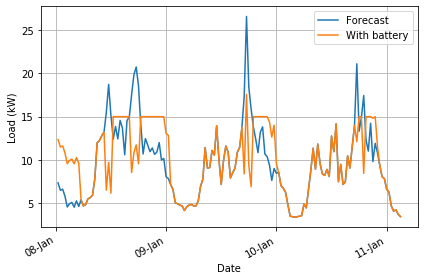

In [5]:
l = 0
h = 150

fig, ax = plt.subplots()
ax.plot(df["Timestamp"].iloc[l+336:h+336], pers[l:h], label="Forecast")
ax.plot(df["Timestamp"].iloc[l+336:h+336], load[l:h], label="With battery")

# Major ticks every day
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.grid(True)
# Set labels to day number - month name
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
# Rotates and right-aligns the x labels to avoid crowding
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax.set_ylabel("Load (kW)")
ax.set_xlabel("Date")
ax.legend()

plt.tight_layout()
plt.savefig("battery_on_forecast_load.jpg", dpi=300, bbox_inches="tight")
plt.show()

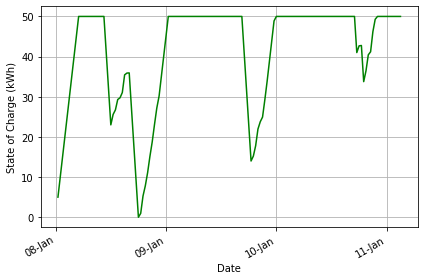

In [6]:
fig, ax = plt.subplots()
ax.plot(df["Timestamp"].iloc[l+336:h+336], battCharge[l:h], color="green", label="SoC")

# Major ticks every day
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.grid(True)
# Set labels to day number - month name
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
# Rotates and right-aligns the x labels to avoid crowding
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')

ax.set_ylabel("State of Charge (kWh)")
ax.set_xlabel("Date")
plt.tight_layout()
#plt.savefig("battery_on_forecast_load_SoC.jpg", dpi=300, bbox_inches="tight")
plt.show()

In [7]:
# Apply model to real loads
realLoads = df["crawfordCrescent_F2"].iloc[336:].values
battChargeInst = 0
battCharge = []
loadInst = 0
load = []

for index, isChargingInst in enumerate(isCharging):
    # Check if battery is scheduled to charge
    if isChargingInst:
        # Check if battery is full
        if battChargeInst > battCapacity:
            # If full, no charge is added and load is the same
            loadInst = realLoads[index]
        else:
            # If there's space in the battery, load will increase by the charge rate
            loadInst = realLoads[index] + chargeRate     
            battChargeInst += chargeRate
    else:
        if battChargeInst >= 0:
            loadInst = realLoads[index] + dischargeRate
            battChargeInst += dischargeRate
        else:
            loadInst = realLoads[index]
    if battChargeInst > battCapacity:
        battChargeInst = 50
    elif battChargeInst < 0:
        battChargeInst = 0
    load.append(loadInst)
    battCharge.append(battChargeInst)

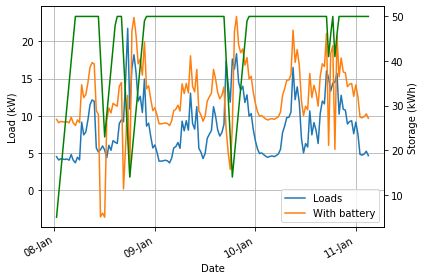

In [8]:
l = 0
h = 150

fig, ax = plt.subplots()
ax.plot(df["Timestamp"].iloc[l+336:h+336], realLoads[l:h], label="Loads")
ax.plot(df["Timestamp"].iloc[l+336:h+336], load[l:h], label="With battery")
ax2 = ax.twinx()
ax2.plot(df["Timestamp"].iloc[l+336:h+336], battCharge[l:h], color="green", label="SoC")
# Major ticks every day
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.grid(True)
# Set labels to day number - month name
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
# Rotates and right-aligns the x labels to avoid crowding
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax.set_ylabel("Load (kW)")
ax.set_xlabel("Date")
ax2.set_ylabel("Storage (kWh)")
ax.legend()

plt.tight_layout()
plt.savefig("battery_on_actual_load.jpg", dpi=300, bbox_inches="tight")
plt.show()

In [24]:
# Limit where battery charge will toggle
trigger = 15
chargeRate = 5
dischargeRate = -9
battChargeInst = 0
battCapacity = 50   # kWh
effi = 0.96
loss = 0.100
period = 0.5

battCharge = []
loadInst = 0
load = []
isCharging = []
# Capacity of battery, look into this more later
# diff > 0 charging, diff < 0 discharing
diff = trigger - pers

for i, x in enumerate(diff):
    if x > chargeRate:
        x = chargeRate
    elif x < dischargeRate:
        x = dischargeRate
    
    if x >= 0:
        battChargeInst += ((x * effi) - loss) * period
        isCharging.append(1)
    else:
        battChargeInst += ((x * (1/effi) - loss)) * period
        isCharging.append(0)
    loadInst = pers[i] + x
    
    if battChargeInst < 0:
        loadInst -= battChargeInst
        battChargeInst = 0
    elif battChargeInst > battCapacity:
        loadInst -= battChargeInst - battCapacity
        battChargeInst = battCapacity
        
    battCharge.append(battChargeInst)
    load.append(loadInst)

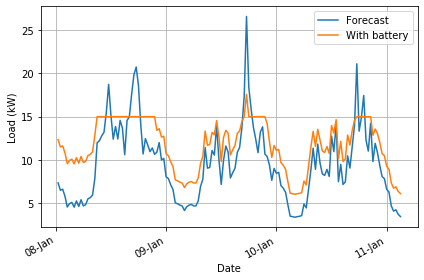

In [25]:
l = 0
h = 150

fig, ax = plt.subplots()
ax.plot(df["Timestamp"].iloc[l+336:h+336], pers[l:h], label="Forecast")
ax.plot(df["Timestamp"].iloc[l+336:h+336], load[l:h], label="With battery")

# Major ticks every day
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.grid(True)
# Set labels to day number - month name
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
# Rotates and right-aligns the x labels to avoid crowding
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax.set_ylabel("Load (kW)")
ax.set_xlabel("Date")
ax.legend()

plt.tight_layout()
plt.savefig("battery_on_forecast_load.jpg", dpi=300, bbox_inches="tight")
plt.show()

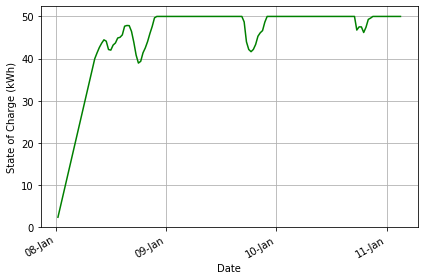

In [26]:
fig, ax = plt.subplots()
ax.plot(df["Timestamp"].iloc[l+336:h+336], battCharge[l:h], color="green", label="SoC")

# Major ticks every day
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.grid(True)
# Set labels to day number - month name
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
# Rotates and right-aligns the x labels to avoid crowding
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')

ax.set_ylabel("State of Charge (kWh)")
ax.set_xlabel("Date")
plt.tight_layout()
#plt.savefig("battery_on_forecast_load_SoC.jpg", dpi=300, bbox_inches="tight")
plt.show()